In [164]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from catalyst import utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_circles

device = torch.device("mps")

In [165]:
def hingeLoss(x, y):
    return torch.max(torch.zeros_like(y), 1-y*x).mean()

### Create Dataset

In [166]:
X, Y = make_circles(1500, factor=0.1, noise=0.1)
X, Y = shuffle(X,Y,random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=250, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=250, random_state=1)

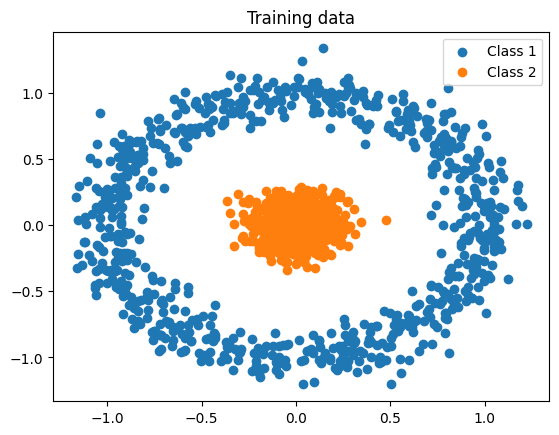

In [167]:
fig, ax = plt.subplots()
ax.scatter(X[np.where(Y==0),0], X[np.where(Y==0),1], label='Class 1')
ax.scatter(X[np.where(Y==1),0], X[np.where(Y==1),1], label='Class 2')
ax.set_title('Training data')
ax.legend();

In [168]:
def BoundaryPlotter(model_linear, x, y, title, levels):
    grid_x, grid_y = torch.meshgrid(torch.arange(x.min()*1.1, x.max()*1.1, step=0.1),
                                    torch.arange(x.min()*1.1, x.max()*1.1, step=0.1))
    x_test_grid = torch.stack((grid_x, grid_y)).reshape(2, -1).transpose(1,0)

    y_test_linear = model_linear(x_test_grid).detach()

    y_test_linear = y_test_linear.transpose(1,0).reshape(grid_x.shape).numpy()
    
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    cs0 = ax.contourf(grid_x.numpy(), grid_y.numpy(), y_test_linear, cmap="Spectral", alpha=0.3)
    ax.contour(cs0, '--', levels=levels, colors='tab:green', linewidths=2)

    ax.plot(np.nan, label='decision boundary', color='tab:green')
    ax.scatter(x[np.where(y==0),0], x[np.where(y==0),1])

    ax.scatter(x[np.where(y==1),0], x[np.where(y==1),1])
    ax.legend()
    ax.set_title(title)

### SVM

In [169]:
class SVM(torch.nn.Module):
    def __init__(self, X, kernel='linear',gamma=1.0,gammaGrad=True,p=2):
        super().__init__()
        assert kernel in ['linear', 'rbf', 'poly']
        self.X = torch.FloatTensor(X)
        
        if kernel == 'linear':
            self._kernel = self.linear
            self._num_c = self.X.shape[1]
        
        elif kernel == 'rbf':
            self._kernel = self.rbf
            self._num_c = self.X.shape[0]
            self._gamma = torch.nn.Parameter(torch.FloatTensor([gamma]),
                                             requires_grad=gammaGrad)
        
        elif kernel == 'poly':
            self._p=p
            self._kernel = self.poly
            self._num_c = self.X.shape[0]
           
        else:
            assert False
            
        self._w = torch.nn.Linear(in_features=self._num_c, out_features=1)

    def rbf(self, x):
        y = self.X.repeat(x.size(0), 1, 1)
        return torch.exp(-self._gamma*((x[:,None]-y)**2).sum(dim=2))

    def poly(self, x, c=1):
        y = self.X.repeat(x.size(0), 1, 1)
        return ((x@(self.X.T))+c) ** self._p
    
    @staticmethod
    def linear(x):
        return x

    def forward(self, x):
        y = self._kernel(x)
        y = self._w(y)
        return y
    
    def train(self, x, y, X_val, y_val, epochs=200, lambda_reg=0):
        x = torch.FloatTensor(x)
        y = 2*y-1
        y = torch.FloatTensor(y)
        X_val = torch.FloatTensor(X_val)
        y_val = 2*y_val-1
        valat=epochs/10
        optim=torch.optim.SGD(self.parameters(), lr=0.01)
        for i in range(epochs):
            optim.zero_grad()
            pred=self(x)
            loss=hingeLoss(pred,y.unsqueeze(1))+lambda_reg*torch.norm(self._w.weight,1)
            loss.backward()
            optim.step()
            ypred=self(X_val).detach()
            ypred=np.sign(ypred.transpose(1,0).numpy().reshape(y_val.shape))
            if i%valat==0:
                print("Validation Accuracy at epoch",i,":",accuracy_score(y_val, ypred))
        print("Training Loss is :",loss.item())
    
    def test(self, x_test, y_test):
        x_test = torch.FloatTensor(x_test)
        y_test = 2*y_test-1
        ypred=self(x_test).detach()
        ypred=np.sign(ypred.transpose(1,0).numpy().reshape(y_test.shape))
        print("Test Accuracy:", accuracy_score(y_test,ypred))

Validation Accuracy at epoch 0 : 0.496
Validation Accuracy at epoch 20 : 0.496
Validation Accuracy at epoch 40 : 0.496
Validation Accuracy at epoch 60 : 0.496
Validation Accuracy at epoch 80 : 0.496
Validation Accuracy at epoch 100 : 0.496
Validation Accuracy at epoch 120 : 0.496
Validation Accuracy at epoch 140 : 0.496
Validation Accuracy at epoch 160 : 0.496
Validation Accuracy at epoch 180 : 0.496
Training Loss is : 0.9980408549308777
Test Accuracy: 0.488


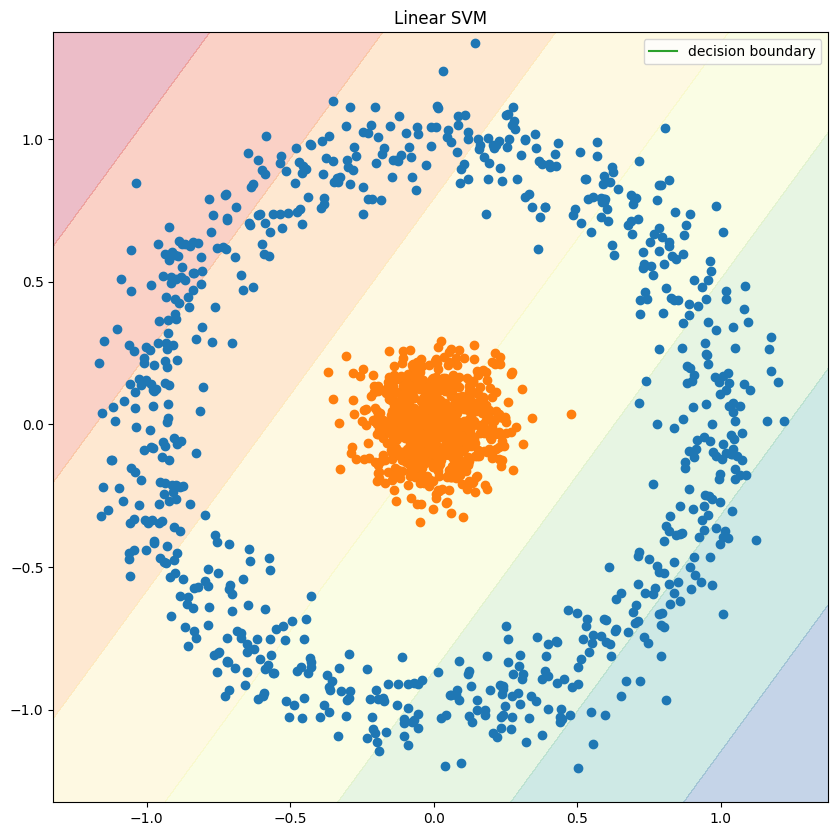

In [170]:
linSVM=SVM(X, kernel='linear')
linSVM.train(X_train, y_train, X_val, y_val)
linSVM.test(X_test, y_test)
BoundaryPlotter(linSVM, X, Y,'Linear SVM', levels=[0])

Validation Accuracy at epoch 0 : 0.504
Validation Accuracy at epoch 20 : 0.504
Validation Accuracy at epoch 40 : 0.504
Validation Accuracy at epoch 60 : 1.0
Validation Accuracy at epoch 80 : 1.0
Validation Accuracy at epoch 100 : 1.0
Validation Accuracy at epoch 120 : 1.0
Validation Accuracy at epoch 140 : 1.0
Validation Accuracy at epoch 160 : 1.0
Validation Accuracy at epoch 180 : 1.0
Training Loss is : 0.0
Test Accuracy: 1.0


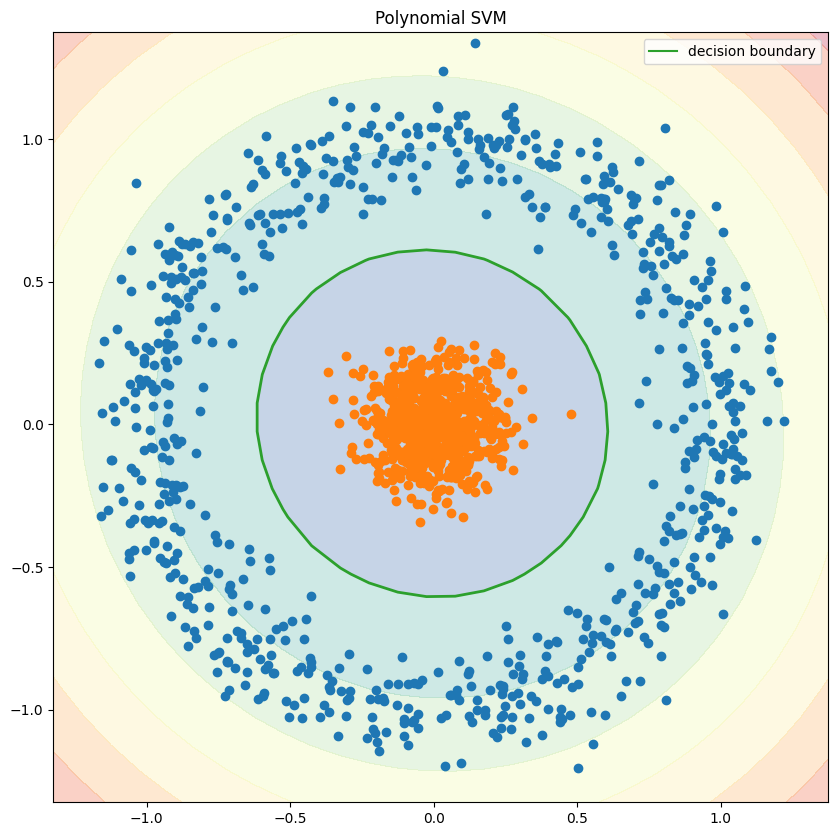

In [171]:
polySVM=SVM(X_train, kernel='poly', p=2)
polySVM.train(X_train, y_train, X_val, y_val)
polySVM.test(X_test, y_test)
BoundaryPlotter(polySVM, X, Y, 'Polynomial SVM', levels=[0])

Validation Accuracy at epoch 0 : 0.496
Validation Accuracy at epoch 20 : 1.0
Validation Accuracy at epoch 40 : 1.0
Validation Accuracy at epoch 60 : 1.0
Validation Accuracy at epoch 80 : 1.0
Validation Accuracy at epoch 100 : 1.0
Validation Accuracy at epoch 120 : 1.0
Validation Accuracy at epoch 140 : 1.0
Validation Accuracy at epoch 160 : 1.0
Validation Accuracy at epoch 180 : 1.0
Training Loss is : 0.003648334415629506
Test Accuracy: 1.0


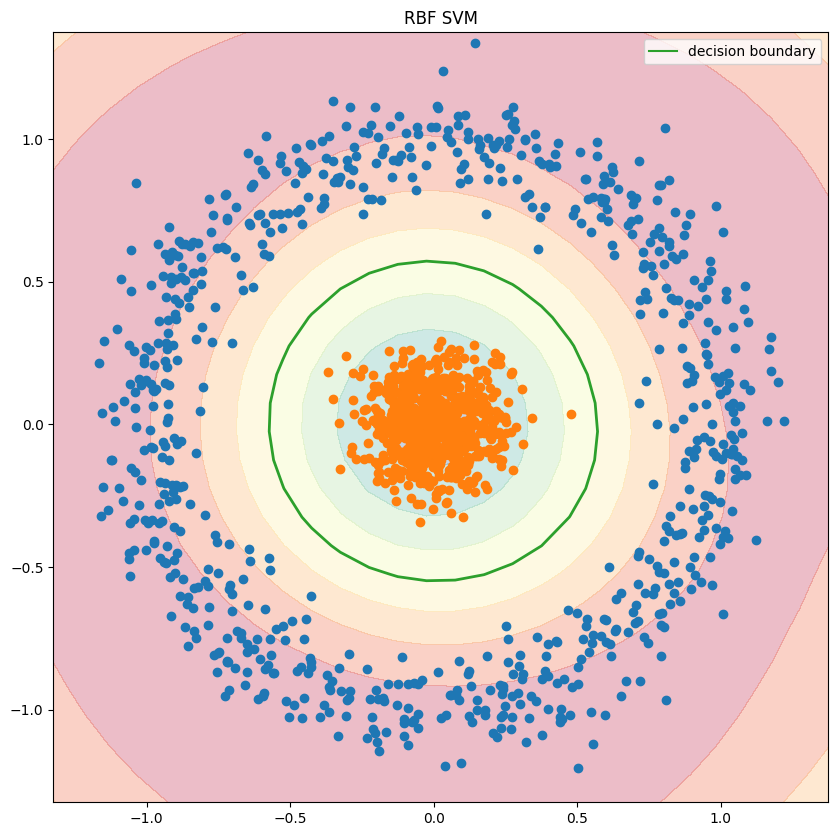

In [172]:
rbfSVM=SVM(X_train, kernel='rbf')
rbfSVM.train(X_train , y_train, X_val, y_val)
rbfSVM.test(X_test, y_test)
BoundaryPlotter(rbfSVM, X, Y, 'RBF SVM', levels=[0])

### Logistic Regression

In [173]:
class LogReg(torch.nn.Module):
    def __init__(self, X,kernel='linear', gamma=1.0, gammaGrad=True, p=2):
        super().__init__()
        assert kernel in ['linear', 'rbf', 'poly']
        self.X = torch.FloatTensor(X)
        
        if kernel == 'linear':
            self._kernel = self.linear
            self._num_c = self.X.shape[1]

        elif kernel == 'rbf':
            self._kernel = self.rbf
            self._num_c = self.X.shape[0]
            self._gamma = torch.nn.Parameter(torch.FloatTensor([gamma]),
                                             requires_grad=gammaGrad)
        
        elif kernel == 'poly':
            self._p=p
            self._kernel = self.poly
            self._num_c = self.X.shape[0] 
           
        else:
            assert False
            
        self._w = torch.nn.Linear(in_features=self._num_c, out_features=1)

    def rbf(self, x):
        y = self.X.repeat(x.size(0), 1, 1)
        return torch.exp(-self._gamma*((x[:,None]-y)**2).sum(dim=2))

    def poly(self, x, c=1):
        y = self.X.repeat(x.size(0), 1, 1)
        return ((x@(self.X.T))+c) ** self._p     
    
    @staticmethod
    def linear(x):
        return x

    def forward(self, x):
        y = self._kernel(x)
        y = self._w(y)
        #For Logistic we use Sigmoid
        return torch.sigmoid(y)
    
    def train(self, x, y, X_val, y_val, epochs=200):
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)
        X_val = torch.FloatTensor(X_val)

        valat=epochs/10
        optim=torch.optim.SGD(self.parameters(),lr=0.01)
        criterion = torch.nn.BCELoss()
        
        for i in range(epochs):
            optim.zero_grad()
            pred=self(x)
            loss=criterion(pred,y.unsqueeze(1))
            loss.backward()
            optim.step()
            if i%valat==0:
                ypred=self(X_val).detach()
                ypred=ypred.transpose(1,0).reshape(y_val.shape).numpy()
                ypred=np.asarray(ypred>=0.5,dtype=np.int64)
                print("Validation Accuracy at epoch",i,":",accuracy_score(y_val,ypred))
        print("Training Loss is :",loss.item())
        
    def test(self, x_test, y_test):
        x_test = torch.FloatTensor(x_test)
        ypred=self(x_test).detach()
        ypred=ypred.transpose(1,0).reshape(y_test.shape).numpy()
        ypred=np.asarray(ypred>=0.5,dtype=np.int64)
        print("Test Accuracy:",accuracy_score(y_test,ypred))


Validation Accuracy at epoch 0 : 0.496
Validation Accuracy at epoch 20 : 0.496
Validation Accuracy at epoch 40 : 0.496
Validation Accuracy at epoch 60 : 0.496
Validation Accuracy at epoch 80 : 0.496
Validation Accuracy at epoch 100 : 0.496
Validation Accuracy at epoch 120 : 0.496
Validation Accuracy at epoch 140 : 0.496
Validation Accuracy at epoch 160 : 0.496
Validation Accuracy at epoch 180 : 0.496
Training Loss is : 0.7000499367713928
Test Accuracy: 0.488


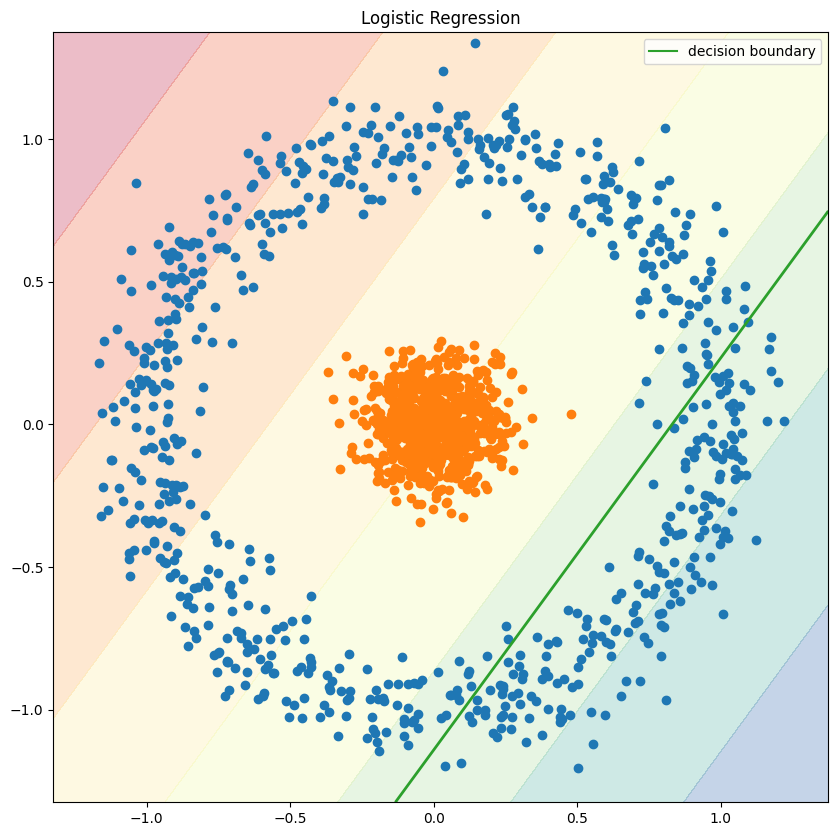

In [174]:
linLog=LogReg(X_train,kernel='linear')
linLog.train(X_train, y_train, X_val, y_val)
linLog.test(X_test, y_test)
BoundaryPlotter(linSVM, X, Y,'Logistic Regression',levels=[0.5])

Validation Accuracy at epoch 0 : 0.504
Validation Accuracy at epoch 30 : 0.98
Validation Accuracy at epoch 60 : 1.0
Validation Accuracy at epoch 90 : 1.0
Validation Accuracy at epoch 120 : 1.0
Validation Accuracy at epoch 150 : 1.0
Validation Accuracy at epoch 180 : 1.0
Validation Accuracy at epoch 210 : 1.0
Validation Accuracy at epoch 240 : 1.0
Validation Accuracy at epoch 270 : 1.0
Training Loss is : 0.039726413786411285
Test Accuracy: 1.0


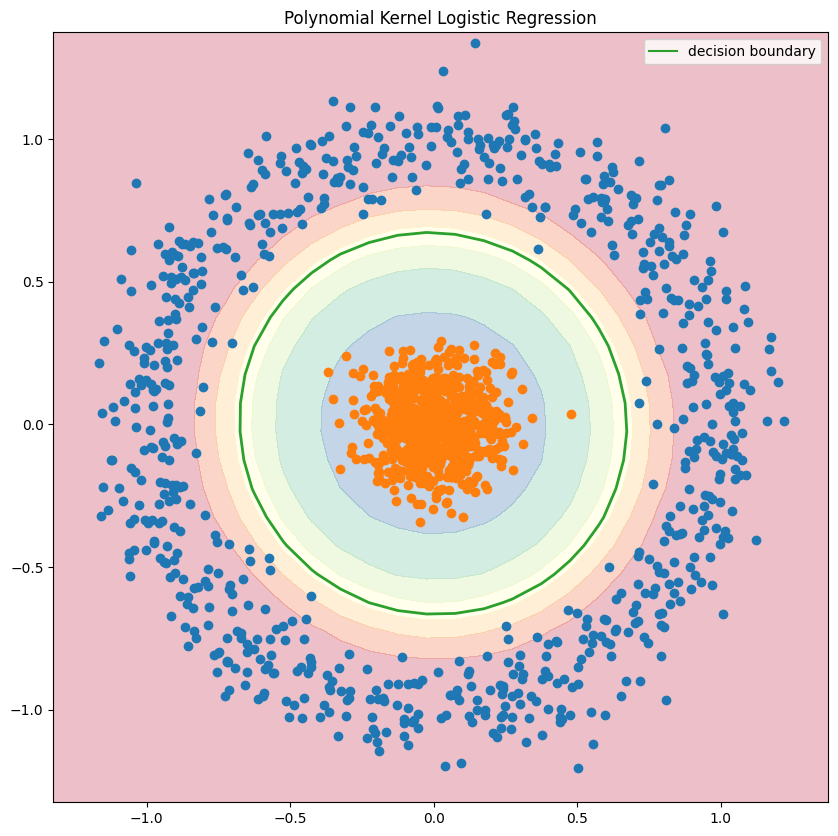

In [175]:
polyLog=LogReg(X_train, kernel='poly', p=2)
polyLog.train(X_train, y_train, X_val, y_val, epochs=300)
polyLog.test(X_test, y_test)
BoundaryPlotter(polyLog, X, Y,'Polynomial Kernel Logistic Regression', levels=[0.5])

Validation Accuracy at epoch 0 : 0.496
Validation Accuracy at epoch 30 : 0.988
Validation Accuracy at epoch 60 : 1.0
Validation Accuracy at epoch 90 : 1.0
Validation Accuracy at epoch 120 : 1.0
Validation Accuracy at epoch 150 : 1.0
Validation Accuracy at epoch 180 : 1.0
Validation Accuracy at epoch 210 : 1.0
Validation Accuracy at epoch 240 : 1.0
Validation Accuracy at epoch 270 : 1.0
Training Loss is : 0.04560709372162819
Test Accuracy: 1.0


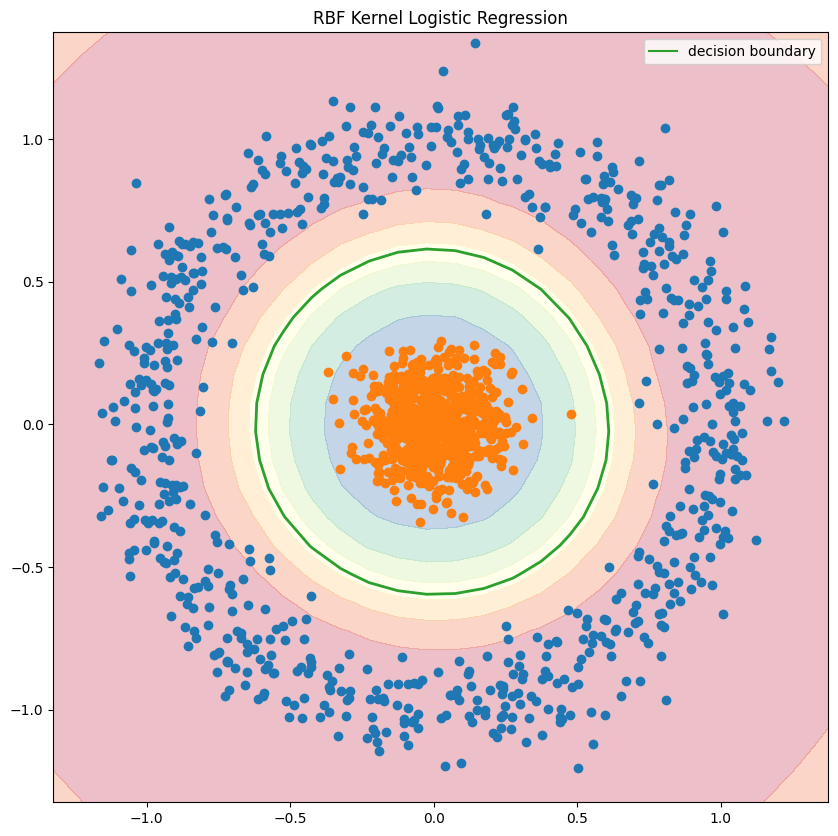

In [176]:
rbfLog=LogReg(X_train, kernel='rbf')
rbfLog.train(X_train, y_train, X_val, y_val, epochs=300)
rbfLog.test(X_test, y_test)
BoundaryPlotter(rbfLog, X, Y,'RBF Kernel Logistic Regression', levels=[0.5])

### KNN

In [177]:
for i in range(1, 5):
    knn = KNeighborsRegressor(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)
    pred_i = np.round(knn.predict(X_val),decimals=0)
    mae = accuracy_score(y_val, pred_i)
    print(f'Accuracy for K={i} is {round(mae,5)}')

Accuracy for K=1 is 1.0
Accuracy for K=2 is 1.0
Accuracy for K=3 is 1.0
Accuracy for K=4 is 1.0


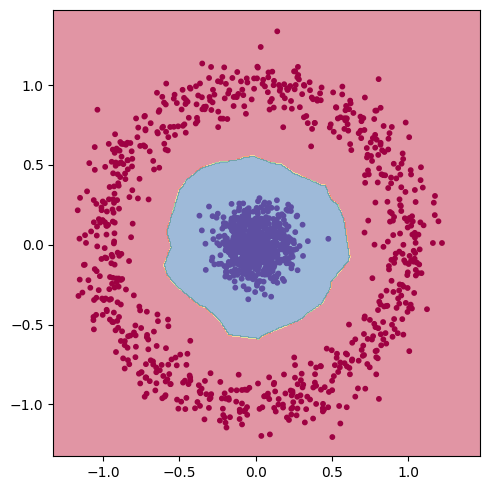

In [178]:
knn = KNeighborsRegressor(n_neighbors=1, weights='distance')
knn.fit(X_train, y_train)
n = 400
x = np.linspace(X.min()*1.1, X.max()*1.1, n)
y = np.linspace(X.min()*1.1, X.max()*1.1, n)
x, y = np.meshgrid(x, y)
xy = np.array(list(map(np.ravel, [x, y]))).T

z = np.round(knn.predict(xy),decimals=0).reshape(x.shape)

plt.figure(figsize=(5, 5))
plt.contourf(x, y, z, alpha=0.5, cmap='Spectral')
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10, cmap='Spectral')
plt.tight_layout()
plt.show()

### Neural Network

In [191]:

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)

def show_loss(losses):
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

def train(model, epochs):
    losses = []
    max_epochs = epochs
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    for _ in range(max_epochs):
        epochloss=0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            outp = model(X_batch)
            loss = loss_function(outp.flatten(), y_batch)
            loss.backward()
            epochloss = epochloss+loss.detach().flatten()[0]
            optimizer.step()
        losses.append(epochloss)
    return model, losses

def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

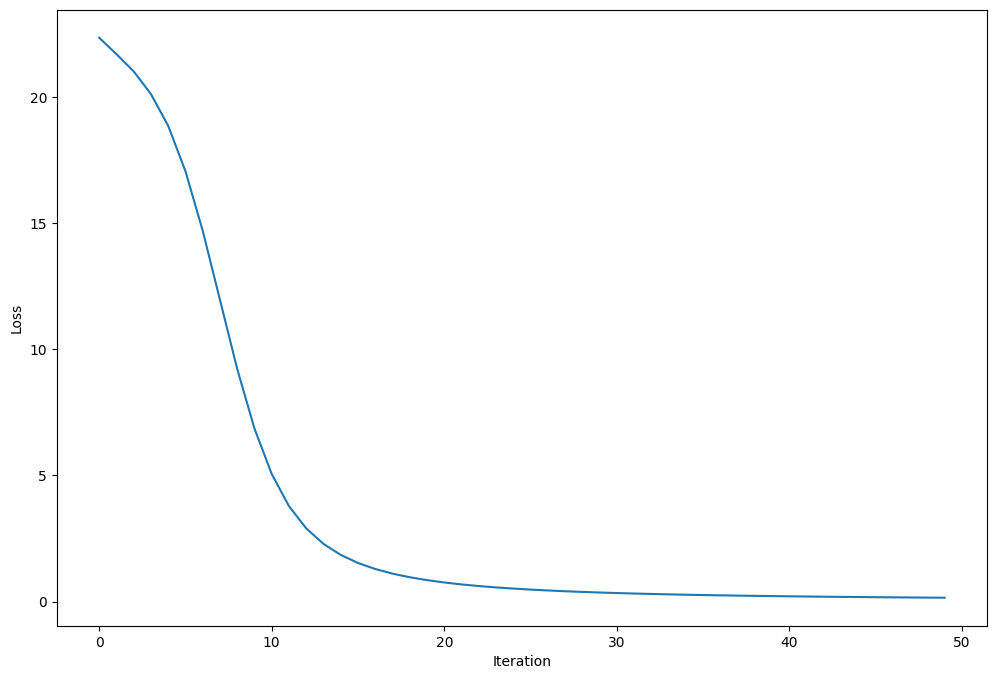

Validation Accuracy: 1.0


In [192]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.ReLU(),
    nn.Linear(30, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

model, losses = train(model, 50)
show_loss(losses)
accuracy = accuracy_score(y_val, predict(val_dataloader, model))

print("Validation Accuracy:",accuracy)

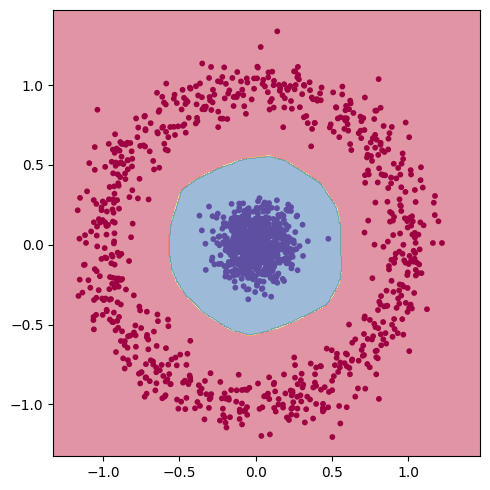

In [196]:
knn = KNeighborsRegressor(n_neighbors=1, weights='distance')
knn.fit(X_train, y_train)
n = 400
x = np.linspace(X.min()*1.1, X.max()*1.1, n)
y = np.linspace(X.min()*1.1, X.max()*1.1, n)
x, y = np.meshgrid(x, y)
xy = np.array(list(map(np.ravel, [x, y]))).T

batch = torch.from_numpy(xy).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(model(batch).reshape(x.shape))
    z = (probs > 0.5).type(torch.long)
    z = z.numpy()

plt.figure(figsize=(5, 5))
plt.contourf(x, y, z, alpha=0.5, cmap='Spectral')
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10, cmap='Spectral')
plt.tight_layout()
plt.show()